In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resized-plant2021/img_sz_640/a8d54d0d96517ab3.jpg
/kaggle/input/resized-plant2021/img_sz_640/ac6902fd1f0f3ce0.jpg
/kaggle/input/resized-plant2021/img_sz_640/d4b7ea94e1c509e2.jpg
/kaggle/input/resized-plant2021/img_sz_640/c780633f9d9d2970.jpg
/kaggle/input/resized-plant2021/img_sz_640/a506c47f0f2d3d61.jpg
/kaggle/input/resized-plant2021/img_sz_640/d4d8689596df6b80.jpg
/kaggle/input/resized-plant2021/img_sz_640/edd8cfc45e503252.jpg
/kaggle/input/resized-plant2021/img_sz_640/9ab326c1951acb7a.jpg
/kaggle/input/resized-plant2021/img_sz_640/f728e036d729a0ad.jpg
/kaggle/input/resized-plant2021/img_sz_640/fce318c6518fd20e.jpg
/kaggle/input/resized-plant2021/img_sz_640/ab89d542c8cb2dc7.jpg
/kaggle/input/resized-plant2021/img_sz_640/fd014f427ee2b807.jpg
/kaggle/input/resized-plant2021/img_sz_640/908749cd1f2be553.jpg
/kaggle/input/resized-plant2021/img_sz_640/8a57ba815538fce1.jpg
/kaggle/input/resized-plant2021/img_sz_640/e1c5fafb48fcc100.jpg
/kaggle/input/resized-plant2021/img_sz_6

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer

pd.set_option("display.max_columns", None)

18632
Index(['image', 'labels'], dtype='object')
AxesSubplot(0.125,0.125;0.775x0.755)


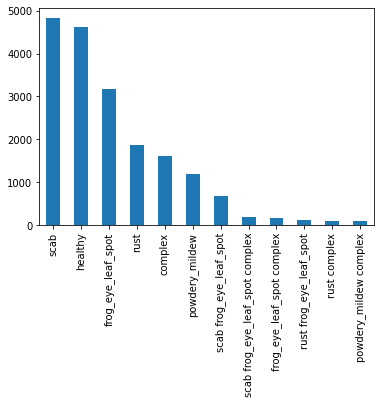

In [3]:
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
print(len(train))
print(train.columns)
# print(train['labels'].value_counts())
print(train['labels'].value_counts().plot.bar())

In [4]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

image                               labels
0      800113bb65efe69e.jpg                            [healthy]
1      8002cb321f8bfcdf.jpg  [scab, frog_eye_leaf_spot, complex]
2      80070f7fb5e2ccaa.jpg                               [scab]
3      80077517781fb94f.jpg                               [scab]
4      800cbf0ff87721f8.jpg                            [complex]
...                     ...                                  ...
18627  fffb900a92289a33.jpg                            [healthy]
18628  fffc488fa4c0e80c.jpg                               [scab]
18629  fffc94e092a59086.jpg                               [rust]
18630  fffe105cf6808292.jpg           [scab, frog_eye_leaf_spot]
18631  fffe472a0001bd25.jpg                            [healthy]

[18632 rows x 2 columns]

Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

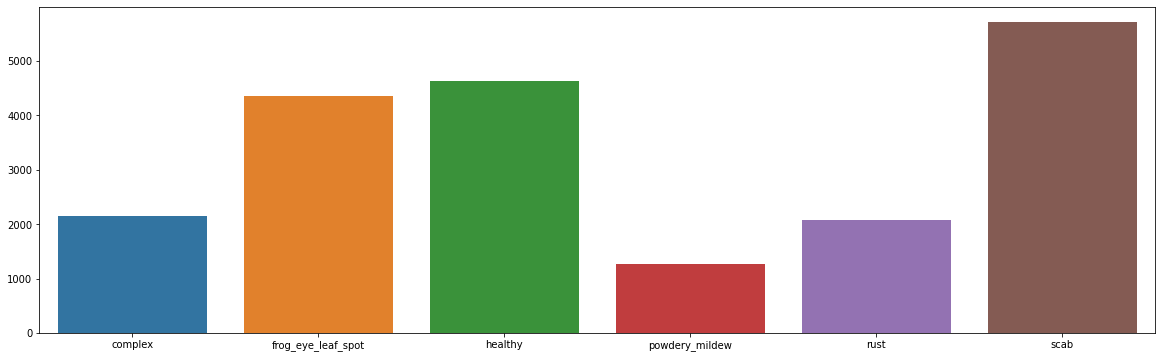

In [5]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

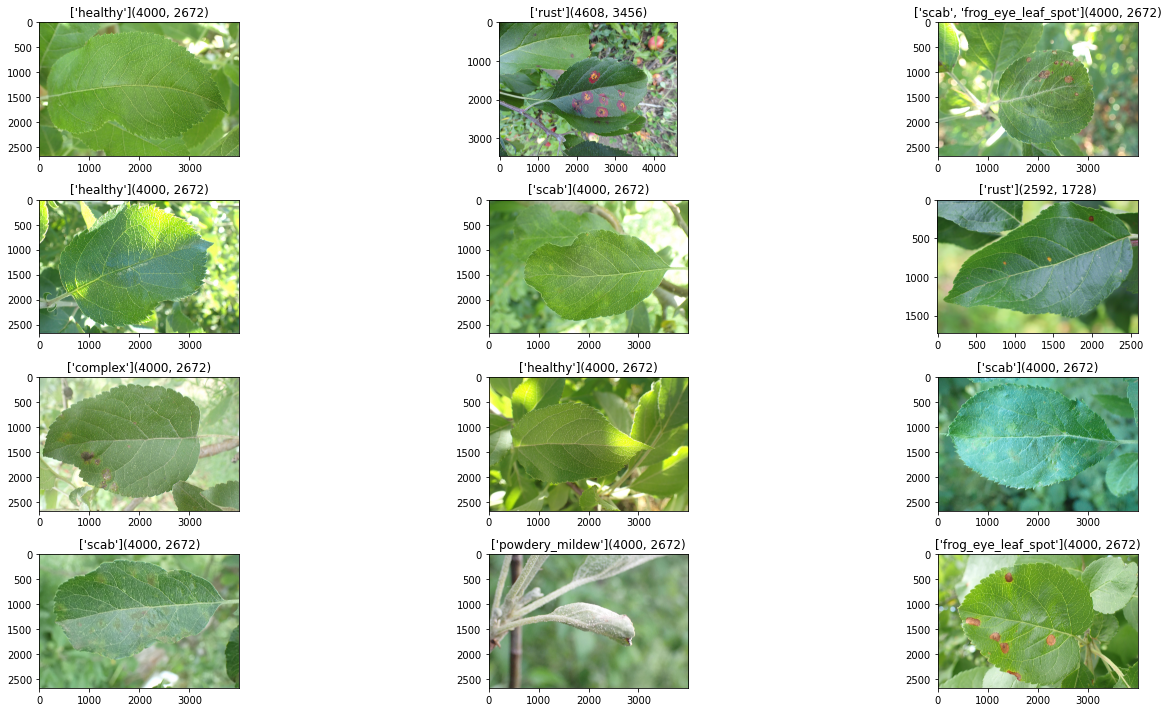

In [6]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, 18000)
    sample = os.path.join('../input/plant-pathology-2021-fgvc8/train_images/', train['image'][rand])
    
    img = PIL.Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [7]:
%%time
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                        preprocessing_function=None,
                                                        data_format=None,
                                                    )

train_data = datagen.flow_from_dataframe(
    train,
    directory='../input/resized-plant2021/img_sz_512',
    x_col="image",
    y_col= 'labels',
    color_mode="rgb",
    target_size = (256,256),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 18632 validated image filenames belonging to 6 classes.
CPU times: user 702 ms, sys: 597 ms, total: 1.3 s
Wall time: 8.07 s


In [8]:
seed = 42
tf.random.set_seed(seed)

weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = keras.applications.InceptionResNetV2(weights=weights_path, include_top=False, input_shape=(256, 256, 3))

print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 1536), dtype=tf.float32, name=None), name='conv_7b_ac/Relu:0', description="created by layer 'conv_7b_ac'")


In [9]:
new_model = tf.keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(6, 
        kernel_initializer=keras.initializers.RandomUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='softmax')
])

# Freezing the weights
for layer in new_model.layers[:-1]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense_top (Dense)            (None, 6)                 9222      
Total params: 54,345,958
Trainable params: 9,222
Non-trainable params: 54,336,736
_________________________________________________________________


In [10]:
f1 = tfa.metrics.F1Score(num_classes=6, average='macro')

callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=5, mode='max', restore_best_weights=True)


new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=1e-3), 
              metrics= [f1])

new_model.fit(train_data, epochs=50, callbacks=callbacks)

Epoch 1/50
583/583 [==============================] - 174s 272ms/step - loss: 0.3733 - f1_score: 0.4223
Epoch 2/50
583/583 [==============================] - 111s 189ms/step - loss: 0.2861 - f1_score: 0.6106
Epoch 3/50
583/583 [==============================] - 111s 191ms/step - loss: 0.2686 - f1_score: 0.6496
Epoch 4/50
583/583 [==============================] - 113s 193ms/step - loss: 0.2534 - f1_score: 0.6698
Epoch 5/50
583/583 [==============================] - 112s 192ms/step - loss: 0.2449 - f1_score: 0.6846
Epoch 6/50
583/583 [==============================] - 112s 193ms/step - loss: 0.2405 - f1_score: 0.6939
Epoch 7/50
583/583 [==============================] - 112s 192ms/step - loss: 0.2371 - f1_score: 0.7017
Epoch 8/50
583/583 [==============================] - 112s 192ms/step - loss: 0.2323 - f1_score: 0.7115
Epoch 9/50
583/583 [==============================] - 113s 193ms/step - loss: 0.2268 - f1_score: 0.7167
Epoch 10/50
583/583 [==============================] - 112s 193m

In [11]:
test = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')

for img_name in tqdm(test['image']):
    path = '../input/plant-pathology-2021-fgvc8/test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./{img_name}')

100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


In [12]:
test_data = datagen.flow_from_dataframe(
    test,
    directory = './',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
print(preds)
preds = preds.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.3:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
[[8.1552804e-04 3.9114224e-04 5.9773034e-04 1.8743785e-05 3.4399366e-04
  9.9783283e-01]
 [2.2923306e-01 4.0927035e-01 3.0041747e-06 1.9446995e-04 4.1581690e-03
  3.5714099e-01]
 [4.3586727e-02 6.6511118e-01 2.3796341e-04 5.2668189e-04 4.9816947e-03
  2.8555569e-01]]
[[5], [1, 5], [1]]


In [13]:
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['scab', 'frog_eye_leaf_spot scab', 'frog_eye_leaf_spot']


In [14]:
delfiles = tf.io.gfile.glob('./*.jpg')

for file in delfiles:
    os.remove(file)

In [15]:
sub = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
sub['labels'] = testlabels
sub.to_csv('submission.csv', index=False)
sub

image                   labels
0  85f8cb619c66b863.jpg                     scab
1  ad8770db05586b59.jpg  frog_eye_leaf_spot scab
2  c7b03e718489f3ca.jpg       frog_eye_leaf_spot